In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn
import warnings # supress warnings
warnings.filterwarnings('ignore')

: 

### Load Data

In [49]:
data_path = "../data/case_study_data_final.csv"
click_data = pd.read_csv(data_path).drop("index", axis=1).drop_duplicates()

### Check Column Types

In [50]:
click_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14760 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   city                  14760 non-null  int64  
 1   district              14760 non-null  int64  
 2   min_booking_duration  14760 non-null  int64  
 3   first_pic_category    13608 non-null  object 
 4   beds                  14760 non-null  int64  
 5   rooms                 14760 non-null  int64  
 6   deposit               14760 non-null  float64
 7   area                  13223 non-null  float64
 8   price                 14759 non-null  float64
 9   accommodates          13189 non-null  float64
 10  number_of_pics        13613 non-null  float64
 11  cleaning_fee          13314 non-null  float64
 12  clicks                14760 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 1.6+ MB


In [51]:
click_data.sample(5)

,city,district,min_booking_duration,first_pic_category,beds,rooms,deposit,area,price,accommodates,number_of_pics,cleaning_fee,clicks
3838,822,923,6,LIVING_DINING_ROOM,1,1,950.0,NaN,950.0,NaN,9.0,NaN,0
4679,349,440,1,ROOM_BEDROOM,1,1,1300.0,40.0,1300.0,1.0,3.0,80.0,0
9500,504,611,12,KITCHEN,1,1,1230.0,32.0,615.0,1.0,6.0,75.0,0
14839,141,601,3,LIVING_DINING_ROOM,2,1,1500.0,33.0,1385.0,2.0,21.0,150.0,2988
1628,1162,1222,1,ROOM_BEDROOM,2,1,600.0,31.0,930.0,2.0,10.0,35.0,0


### Explore Label

Label Descriptions

In [52]:
click_data[["clicks"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
clicks,14760.0,374.056504,940.551328,0.0,0.0,97.5,475.0,38458.0


About 40% of the data have clicks equal to 0

In [53]:
len(click_data[click_data.clicks==0])/len(click_data)

0.3921409214092141

### Explore full Data

#### Create a Description Data containing Missing values Unique values and Types 

In [55]:
# City and District are Categorical
click_data["city"] = click_data["city"].astype(object)
click_data["district"] = click_data["district"].astype(object)

def get_column_type(col):
    return str(click_data[col].dtype)
# Create Unique Values Counts
counts = pd.DataFrame(click_data.nunique()).reset_index()
counts.columns = ["features", "unique_values"]
# Count Missing Values
total = click_data.isnull().sum().sort_values(ascending=False)
percent = (click_data.isnull().sum()/click_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['total_missing', 'ratio_missing']).reset_index()
missing_data.columns = ["features", "total_missing", "ratio_missing"]
description = pd.merge(missing_data, counts, on="features")
# Check Type Column
description["type"] = description["features"].apply(get_column_type)
description.sort_values(by = "type")

,features,total_missing,ratio_missing,unique_values,type
0,accommodates,1571,0.106436,20,float64
1,area,1537,0.104133,377,float64
2,cleaning_fee,1446,0.097967,161,float64
4,number_of_pics,1147,0.077710,90,float64
5,price,1,0.000068,1155,float64
7,deposit,0,0.000000,814,float64
6,clicks,0,0.000000,1943,int64
8,rooms,0,0.000000,14,int64
9,beds,0,0.000000,17,int64
10,min_booking_duration,0,0.000000,19,int64


### Feature Engineering

#### City and District

In [11]:
city_data = click_data.groupby("city").agg({"clicks": "mean", "city": "count"})\
                  .rename({"city": "count"}, axis=1)\
                  .apply(lambda x:round(x,2))\
                  .sort_values(by="count", ascending=False)

district_data = click_data.groupby("district").agg({"clicks": "mean", "district": "count"})\
                  .rename({"district": "count"}, axis=1)\
                  .apply(lambda x:round(x,2))\
                  .sort_values(by="count", ascending=False)
city_data.head(10)

,clicks,count
city,,
141,498.44,5338
465,272.46,1298
822,324.66,1071
271,330.33,836
349,307.75,737
656,243.90,705
1194,329.12,259
888,390.74,254
701,436.54,209


<AxesSubplot:xlabel='count', ylabel='clicks'>

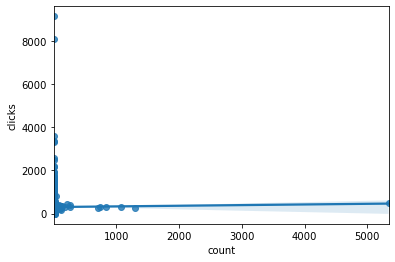

In [12]:
sns.regplot(x="count", y="clicks", data=city_data, fit_reg=True)

<AxesSubplot:xlabel='count', ylabel='clicks'>

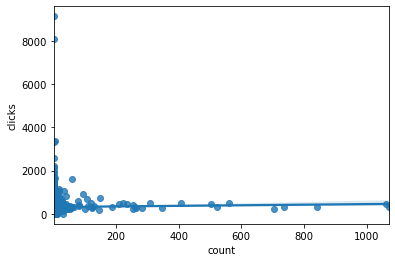

In [13]:
sns.regplot(x="count", y="clicks", data=district_data, fit_reg=True)

In [14]:
district_data[["count"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
count,957.0,15.423197,77.794895,1.0,1.0,2.0,4.0,1070.0


<AxesSubplot:xlabel='district'>

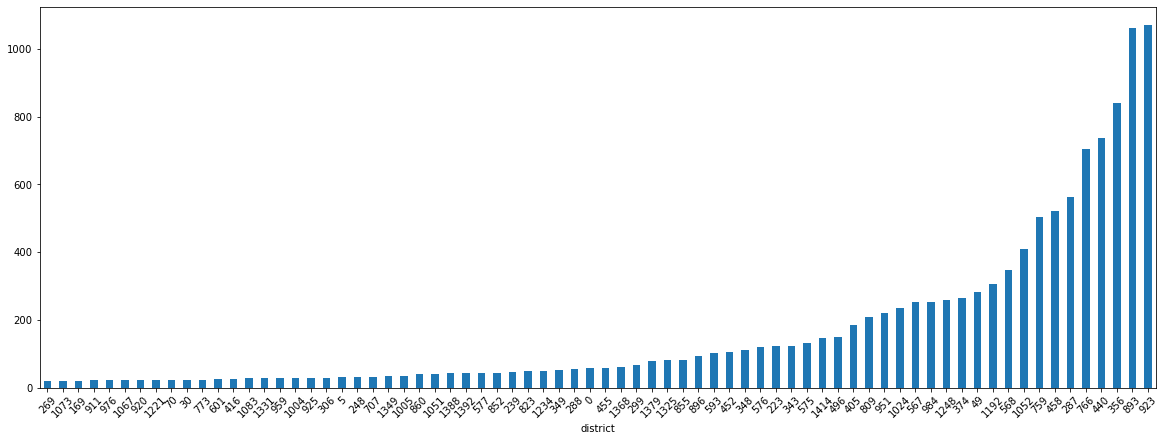

In [15]:
district_data[district_data["count"]>20]["count"].sort_values()\
                        .plot(kind="bar", figsize=(20,7), rot = 45)

In [19]:
city_data[["count"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
count,905.0,16.309392,191.578923,1.0,1.0,1.0,3.0,5338.0


<AxesSubplot:xlabel='city'>

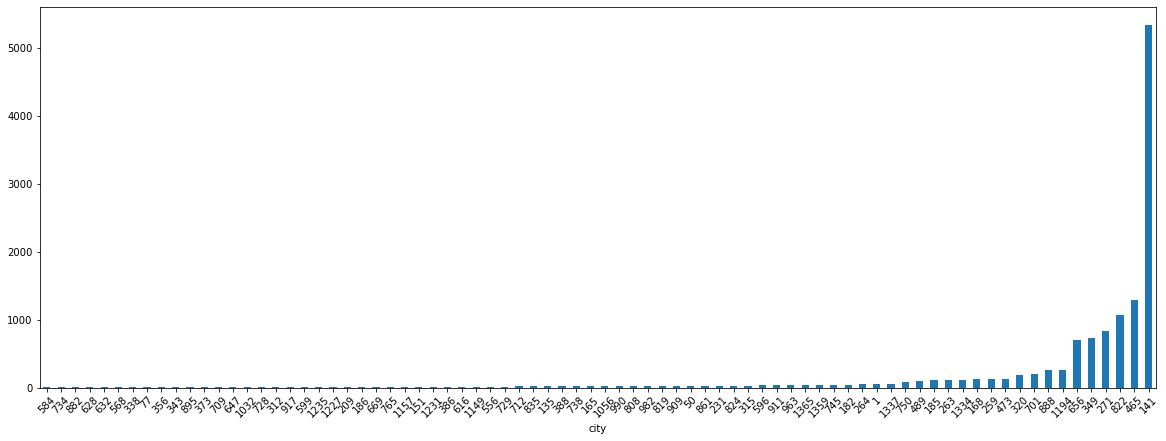

In [20]:
city_data[city_data["count"]>10]["count"].sort_values()\
                        .plot(kind="bar", figsize=(20,7), rot = 45)

Dropping city as it can be used interchangeably with District

In [21]:
click_data = click_data.drop(columns=["city"]).drop_duplicates()

### Handling Missing Values

#### Check missing values Ratio

In [57]:
description[["features","total_missing", "ratio_missing"]]

,features,total_missing,ratio_missing
0,accommodates,1571,0.106436
1,area,1537,0.104133
2,cleaning_fee,1446,0.097967
3,first_pic_category,1152,0.078049
4,number_of_pics,1147,0.077710
5,price,1,0.000068
6,clicks,0,0.000000
7,deposit,0,0.000000
8,rooms,0,0.000000
9,beds,0,0.000000


#### Imputing missing values

In [58]:
# Imputing Area with Median
area_median = click_data.area.median()
click_data.area = click_data.area.fillna(area_median)

# Imputing Cleaning fee with Median
cleaning_fee_median = click_data.cleaning_fee.median()
click_data.cleaning_fee = click_data.cleaning_fee.fillna(cleaning_fee_median)

# Imputing first_pic_category with UNCATEGORIZED
click_data.first_pic_category = click_data.first_pic_category.fillna("UNCATEGORIZED")

# Imputing number_of_pics with 0
click_data.number_of_pics = click_data.number_of_pics.fillna(0)

### Create new features

One feature that might be important is the ratio between deposit and price

In [59]:
click_data["deposit_ratio"] = click_data["deposit"]/click_data["price"]

### Study Correlation

<AxesSubplot:>

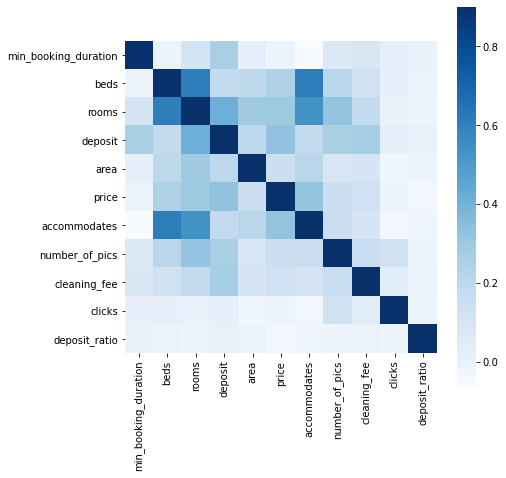

In [60]:
corr = click_data.corr()
plt.subplots(figsize=(7,7))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)

Some interesting correlations:
* beds and accomodates
* rooms and beds

No correlation found between any feature and clicks.
We will keep only number of rooms

In [26]:
click_data = click_data.drop(["beds", "accommodates"], axis=1).drop_duplicates()

number_of_pics is the most correlated feature with number of clicks

<AxesSubplot:xlabel='number_of_pics', ylabel='clicks'>

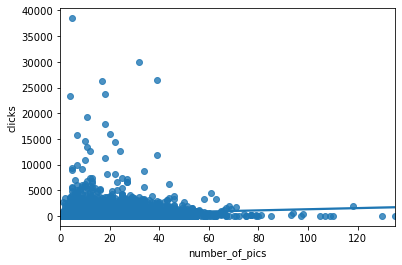

In [27]:
sns.regplot(x="number_of_pics", y="clicks", data=click_data, fit_reg=True, )

### Removing Abnormal Data Points

In [61]:
click_data = click_data[['district', 'min_booking_duration', 'first_pic_category', 'rooms',
       'deposit', 'area', 'price', 'number_of_pics', 'cleaning_fee', 'deposit_ratio', 'clicks']]

In [62]:
click_data.describe()

,min_booking_duration,rooms,deposit,area,price,number_of_pics,cleaning_fee,deposit_ratio,clicks
count,14760.000000,14760.000000,14760.000000,14760.000000,14759.000000,14760.000000,14760.000000,1.475900e+04,14760.000000
mean,2.728117,1.947019,1696.496138,61.554661,1598.849860,14.395122,91.802033,inf,374.056504
std,2.373572,1.089111,1457.775447,78.026941,1564.802199,10.894363,120.173621,NaN,940.551328
min,1.000000,0.000000,0.000000,-41.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.000000,1.000000,746.750000,40.000000,1000.000000,7.000000,40.000000,7.462687e-01,0.000000
50%,2.000000,2.000000,1450.000000,55.000000,1390.000000,12.000000,80.000000,1.000000e+00,97.500000
75%,3.000000,2.000000,2200.000000,72.000000,1850.000000,20.000000,130.000000,1.538462e+00,475.000000
max,50.000000,22.000000,24122.000000,6433.000000,100000.000000,135.000000,10000.000000,inf,38458.000000


In [63]:
click_data = click_data.loc[click_data["area"]>10]
click_data = click_data.loc[click_data["price"]>100]

In [64]:
click_data.describe()

,min_booking_duration,rooms,deposit,area,price,number_of_pics,cleaning_fee,deposit_ratio,clicks
count,14561.000000,14561.000000,14561.000000,14561.000000,14561.000000,14561.000000,14561.000000,14561.000000,14561.000000
mean,2.745347,1.959206,1711.540760,62.138438,1600.388812,14.508825,92.586842,1.119095,378.105075
std,2.382453,1.090096,1461.117247,78.339742,1328.659540,10.882953,120.705814,0.636485,945.261623
min,1.000000,0.000000,0.000000,11.000000,140.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,790.000000,41.000000,1019.000000,7.000000,49.000000,0.753769,0.000000
50%,2.000000,2.000000,1490.000000,55.000000,1390.000000,12.000000,80.000000,1.000000,103.000000
75%,3.000000,2.000000,2200.000000,73.000000,1850.000000,20.000000,140.000000,1.538462,482.000000
max,50.000000,22.000000,24122.000000,6433.000000,80801.000000,135.000000,10000.000000,12.432432,38458.000000


In [65]:
len(click_data)

14561

In [33]:
click_data.columns

Index(['district', 'min_booking_duration', 'first_pic_category', 'rooms',
       'deposit', 'area', 'price', 'number_of_pics', 'cleaning_fee',
       'deposit_ratio', 'clicks'],
      dtype='object')

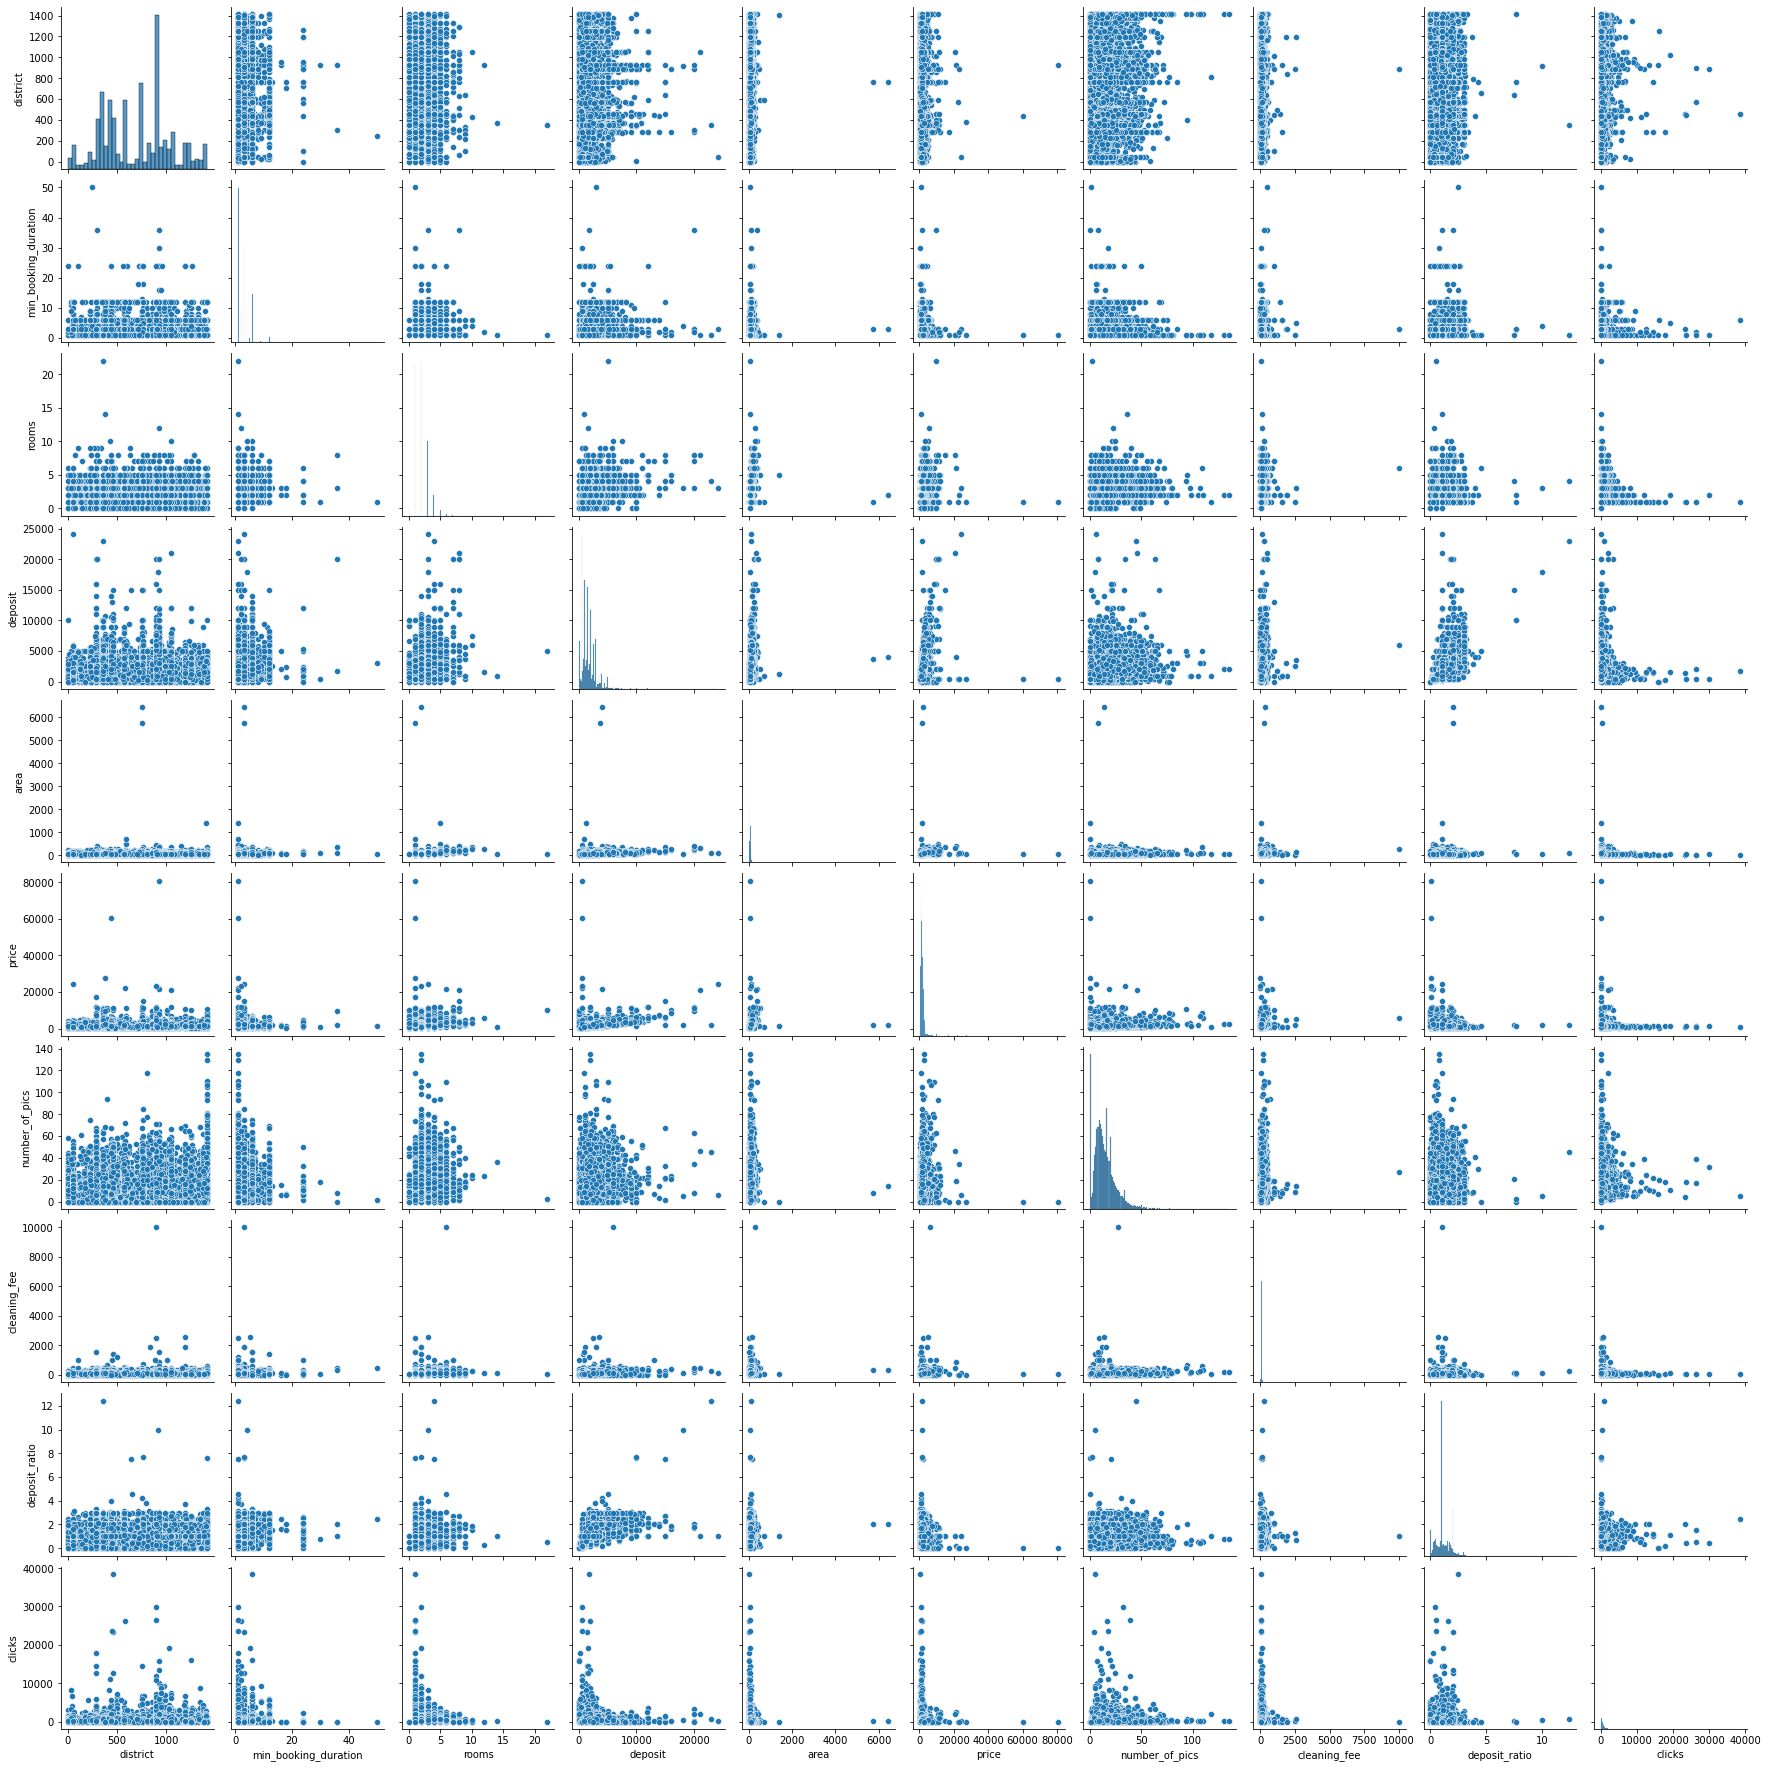

In [34]:
sns.pairplot(click_data, size = 2.5)
plt.show()

### Encoding Categorical Variables

#### District

From the graph analysis above we can create a decomposition of District column based on how popular it iis on our dataset

In [35]:
def district_decomposition(count,decomp):
    if count <=decomp[0]:
        return 1
    if decomp[0]<count<=decomp[1]:
        return 2
    if decomp[1]<count<=decomp[2]:
        return 3
    if count>decomp[2]:
        return 4

Decomposition is based over the plot we had earlier that described how frequent/popular some district were in our Dataset

In [36]:
district_data["district_popularity"] = district_data["count"].apply(lambda x:district_decomposition(x, [10,50, 700]))

In [37]:
district_data

,clicks,count,district_popularity
district,,,
923,324.25,1070,4
893,473.02,1061,4
356,330.10,841,4
440,307.75,737,4
766,243.90,705,4
...,...,...,...
735,202.00,1,1
734,544.00,1,1
732,736.00,1,1


In [38]:
click_data = pd.merge(click_data, district_data.reset_index()[["district", "district_popularity"]], on="district")

In [39]:
click_data = click_data.drop("district", axis=1)

(-0.5, 3.5, 0.0, 40000.0)

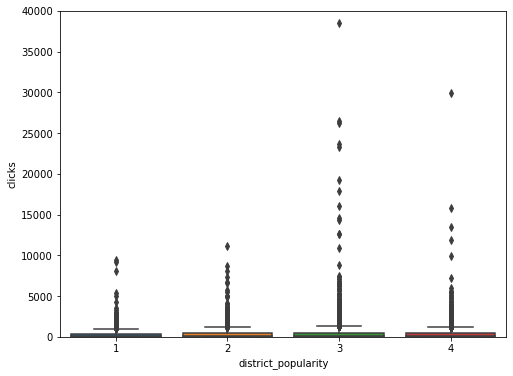

In [40]:
data = pd.concat([click_data['clicks'], click_data['district_popularity']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=click_data['district_popularity'], y="clicks", data=data)
fig.axis(ymin=0, ymax=40000)

#### Encoding First pic Category  

Using Onehot Encoding 

In [41]:
X = pd.get_dummies(click_data, columns=['first_pic_category'])

### Saving the Data

In [42]:
X.to_csv("../data/preprocessed_data.csv", index = False)

In [47]:
district_data["district_popularity"].to_json('../artefacts/district_mapping.json')